In [1152]:
# import the necessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.nn.functional as F

from einops import rearrange, repeat
from einops.layers.torch import Rearrange
import numpy as np

In [1153]:
data_path = '../data/VTT_ConIot_Dataset'
IMU_path = data_path + '/IMU'
Keypoint_path = data_path + '/Keypoint'


In [1154]:
# Load activity 1 for user 1
keypoint_data = pd.read_csv(Keypoint_path + '/Subject_01_Task_2.m2ts_keyPoints.csv')
imu_data = pd.read_csv(IMU_path + '/activity_2_user_1_combined.csv')

In [1155]:
print(keypoint_data.head())
print(imu_data.head())

print(keypoint_data.shape)
print(imu_data.shape)

print(keypoint_data.columns)
print(imu_data.columns)

print(keypoint_data.describe())
print(imu_data.describe())

   frame_number  timestamp       x0       y0   prob0       x1       y1  \
0             0          0  928.239  194.085  0.5061  932.548  182.574   
1             1         40  935.100  223.265  0.4153  937.980  204.547   
2             2         80  930.845  254.145  0.4246  935.152  242.626   
3             3        120  931.124  271.239  0.6784  933.997  258.300   
4             4        160  934.555  275.369  1.4008  934.555  262.432   

    prob1       x2       y2  ...      x14      y14  prob14      x15      y15  \
0  0.6430  912.438  182.574  ...  833.434  690.489  0.1099  916.747  843.008   
1  0.3984  919.259  208.867  ...  834.294  707.056  0.1188  910.619  862.560   
2  0.5136  912.182  242.626  ...  837.528  720.672  0.1187  900.697  870.421   
3  0.5938  916.761  256.863  ...  849.254  718.348  0.1784  898.089  870.739   
4  1.6705  917.356  262.432  ...  854.291  720.982  0.1862  895.857  869.041   

   prob15      x16      y16  prob16  detection_score  
0  0.1253  819.070 

In [1156]:
# for column date time in imu_data, change to time stamp starting from 0
# first remove the "0 days " substring from the datetime column strings
imu_data['datetime'] = imu_data['datetime'].str.replace('0 days ', '')
imu_data['datetime'] = pd.to_datetime(imu_data['datetime'])
# convert to milliseconds
imu_data['datetime'] = imu_data['datetime'].astype(np.int64) / 1000000
# round off and convert to int
imu_data['datetime'] = imu_data['datetime'].round()
# keep only difference staring from 0
imu_data['datetime'] = imu_data['datetime'] - imu_data['datetime'].min()


C:\Users\Azhar\AppData\Local\Temp\ipykernel_26220\1766893211.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  imu_data['datetime'] = pd.to_datetime(imu_data['datetime'])


In [1157]:
print(imu_data['datetime'].head(100))

0       0.0
1      10.0
2      20.0
3      30.0
4      40.0
      ...  
95    950.0
96    960.0
97    970.0
98    980.0
99    990.0
Name: datetime, Length: 100, dtype: float64


In [1158]:
print(imu_data['datetime'].max())
print(keypoint_data['timestamp'].max())

59980.0
60320


In [1159]:
print(imu_data['datetime'].shape)
print(keypoint_data['timestamp'].shape)

# NOTE TO SELF: The timestamps are not the same. Simple solution would be to ignore the extra time stamps once they are brought dow nto the same frequency.

(5999,)
(1509,)


In [1160]:
# check for any non numeric values in the imu data
print(imu_data.dtypes)

datetime            float64
trousers_index      float64
trousers_Gx_dps     float64
trousers_Gy_dps     float64
trousers_Gz_dps     float64
trousers_Ax_g       float64
trousers_Ay_g       float64
trousers_Az_g       float64
trousers_ts         float64
trousers_Mx_uT      float64
trousers_My_uT      float64
trousers_Mz_uT      float64
trousers_mbar       float64
trousers_tot_g      float64
trousers_tot_dps    float64
back_index          float64
back_Gx_dps         float64
back_Gy_dps         float64
back_Gz_dps         float64
back_Ax_g           float64
back_Ay_g           float64
back_Az_g           float64
back_ts             float64
back_Mx_uT          float64
back_My_uT          float64
back_Mz_uT          float64
back_mbar           float64
back_tot_g          float64
back_tot_dps        float64
hand_index          float64
hand_Gx_dps         float64
hand_Gy_dps         float64
hand_Gz_dps         float64
hand_Ax_g           float64
hand_Ay_g           float64
hand_Az_g           

In [1161]:
imu_start = 2000
imu_end = 2400

keypoint_start = 500
keypoint_end = 600

In [1162]:
def plot():
    # # plot rows of the imu data
    # plt.figure(figsize=(25, 5))
    # plt.plot(imu_data['datetime'][imu_start:imu_end], imu_data['hand_Ax_g'][imu_start:imu_end])
    # plt.plot(imu_data['datetime'][imu_start:imu_end], imu_data['hand_Ay_g'][imu_start:imu_end])
    # plt.plot(imu_data['datetime'][imu_start:imu_end], imu_data['hand_Az_g'][imu_start:imu_end])
    # # show the legend
    # plt.legend(['hand_Ax_g', 'hand_Ay_g', 'hand_Az_g'])
    # plt.show()

    # plot magnitude of the acceleration
    plt.figure(figsize=(25, 5))
    plt.plot(imu_data['datetime'][imu_start:imu_end],
             np.sqrt(imu_data['hand_Ax_g'][imu_start:imu_end] ** 2 + imu_data['hand_Ay_g'][imu_start:imu_end] ** 2 +
                     imu_data['hand_Az_g'][imu_start:imu_end] ** 2))
    plt.show()

    # plot rows of the keypoint data
    plt.figure(figsize=(25, 5))
    plt.plot(keypoint_data['timestamp'][keypoint_start:keypoint_end], keypoint_data['x5'][keypoint_start:keypoint_end])
    plt.plot(keypoint_data['timestamp'][keypoint_start:keypoint_end], keypoint_data['y5'][keypoint_start:keypoint_end])
    plt.plot(keypoint_data['timestamp'][keypoint_start:keypoint_end], keypoint_data['x6'][keypoint_start:keypoint_end])
    plt.plot(keypoint_data['timestamp'][keypoint_start:keypoint_end], keypoint_data['y6'][keypoint_start:keypoint_end])
    # show the legend
    plt.legend(['x5', 'y5', 'x6', 'y6'])
    plt.show()

    plt.figure(figsize=(25, 5))
    plt.plot(keypoint_data['timestamp'][keypoint_start:keypoint_end], keypoint_data['x9'][keypoint_start:keypoint_end])
    plt.plot(keypoint_data['timestamp'][keypoint_start:keypoint_end], keypoint_data['y9'][keypoint_start:keypoint_end])
    plt.plot(keypoint_data['timestamp'][keypoint_start:keypoint_end], keypoint_data['x10'][keypoint_start:keypoint_end])
    plt.plot(keypoint_data['timestamp'][keypoint_start:keypoint_end], keypoint_data['y10'][keypoint_start:keypoint_end])
    # show the legend
    plt.legend(['x9', 'y9', 'x10', 'y10'])
    plt.show()

In [1163]:
#filter the data with a bandpass filter, 0.5Hz to 20Hz, frequency is 400Hz
from scipy import signal
from scipy.signal import butter, freqz, filtfilt


def lowpass_filter(data, low_cut_off=0.1, fs=100):
    b, a = butter(4, low_cut_off, fs=fs, btype='lowpass', analog=False)
    y = filtfilt(b, a, data)
    return b, a, y


def highpass_filter(data, high_cut_off=0.1, fs=100):
    b, a = butter(4, high_cut_off, fs=fs, btype='highpass', analog=False)
    y = filtfilt(b, a, data)
    return b, a, y

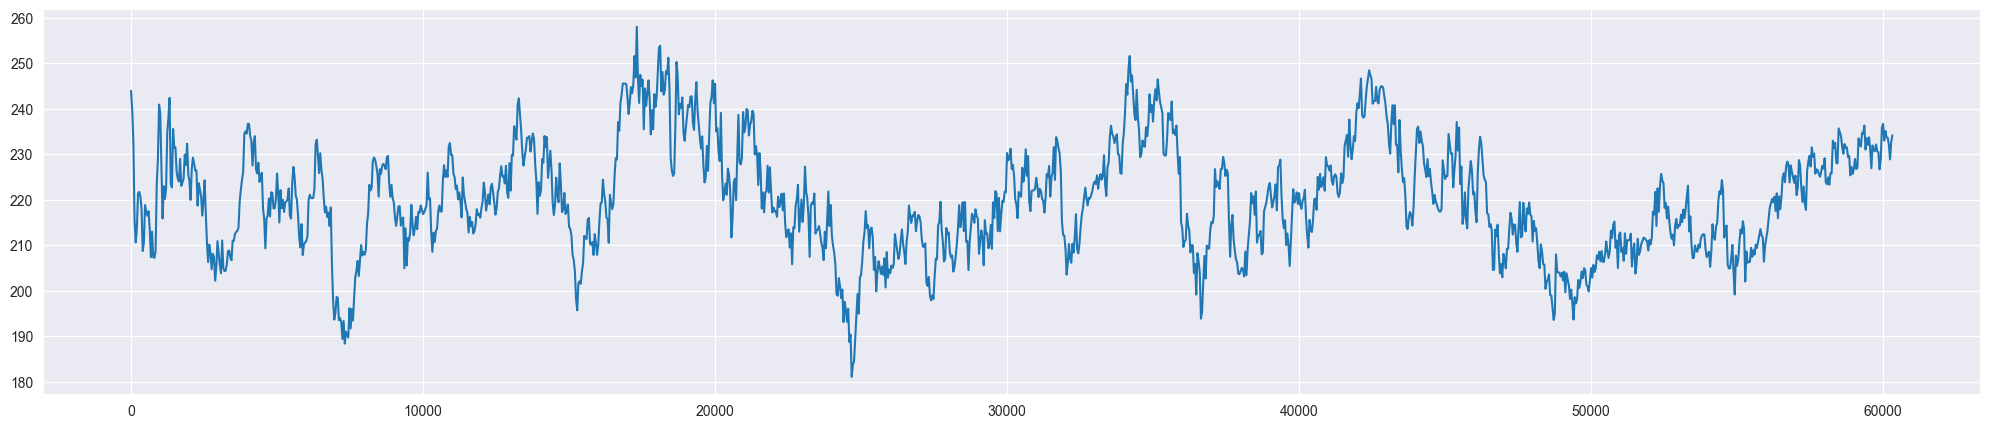

In [1164]:
shoulder_mean_x = (keypoint_data['x5'] + keypoint_data['x6']) / 2
shoulder_mean_y = (keypoint_data['y5'] + keypoint_data['y6']) / 2

hip_mean_x = (keypoint_data['x11'] + keypoint_data['x12']) / 2
hip_mean_y = (keypoint_data['y11'] + keypoint_data['y12']) / 2

distance = np.sqrt((shoulder_mean_x - hip_mean_x) ** 2 + (shoulder_mean_y - hip_mean_y) ** 2)

plt.figure(figsize=(25, 5))
plt.plot(keypoint_data['timestamp'], distance)
plt.show()

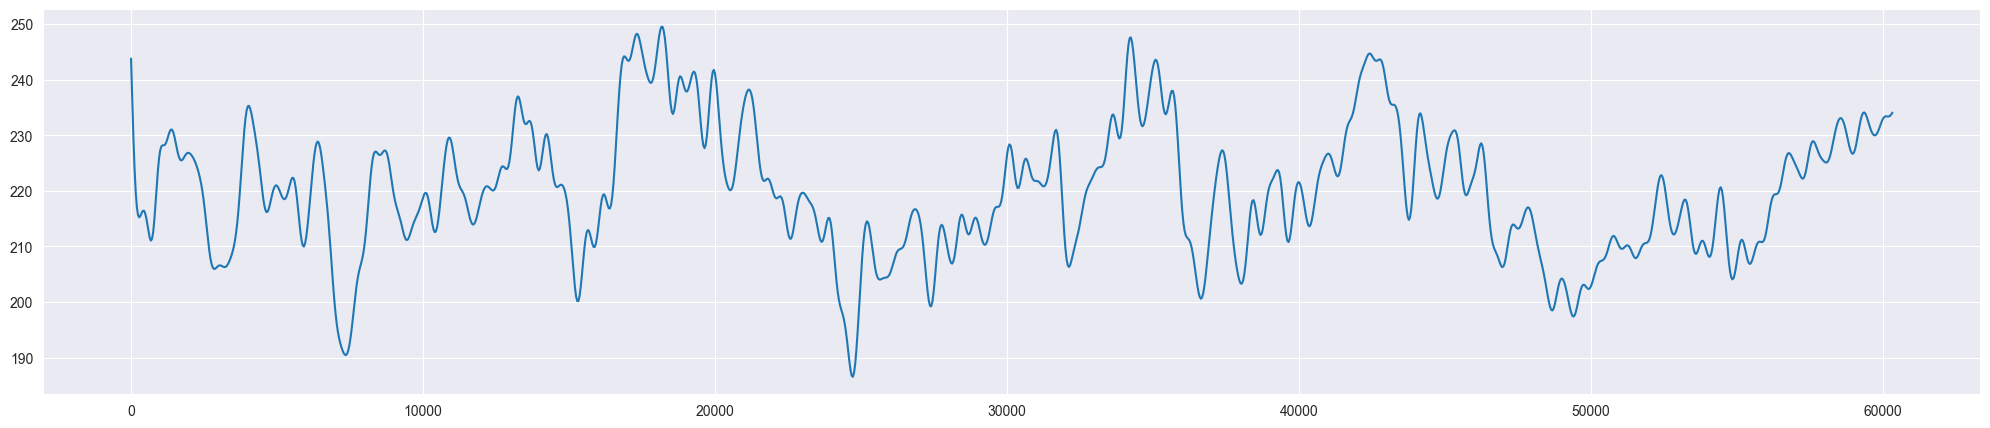

In [1165]:
# remove the high frequency noise from the distance data
b, a, distance = lowpass_filter(distance, low_cut_off=2, fs=25)
plt.figure(figsize=(25, 5))
plt.plot(keypoint_data['timestamp'], distance)
plt.show()

In [1166]:
''' Use the mean of the left and the right shoulder as the root point'''
x_root = (keypoint_data['x5'] + keypoint_data['x6']) / 2
y_root = (keypoint_data['y5'] + keypoint_data['y6']) / 2
prob_root = (keypoint_data['prob5'] + keypoint_data['prob6']) / 2

# get the x9, y9 and x10, y10 relative to root
keypoint_data['x5'] = keypoint_data['x5'] - x_root
keypoint_data['y5'] = keypoint_data['y5'] - y_root
keypoint_data['x6'] = keypoint_data['x6'] - x_root
keypoint_data['y6'] = keypoint_data['y6'] - y_root
keypoint_data['x9'] = keypoint_data['x9'] - x_root
keypoint_data['y9'] = keypoint_data['y9'] - y_root
keypoint_data['x10'] = keypoint_data['x10'] - x_root
keypoint_data['y10'] = keypoint_data['y10'] - y_root



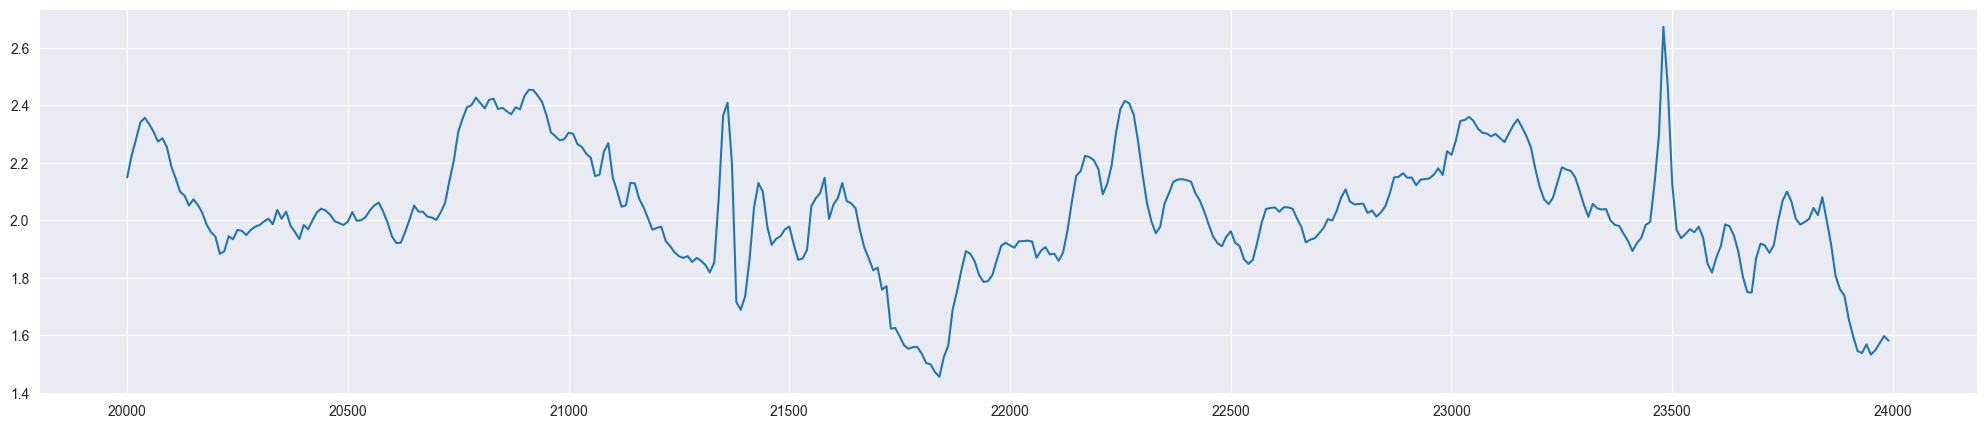

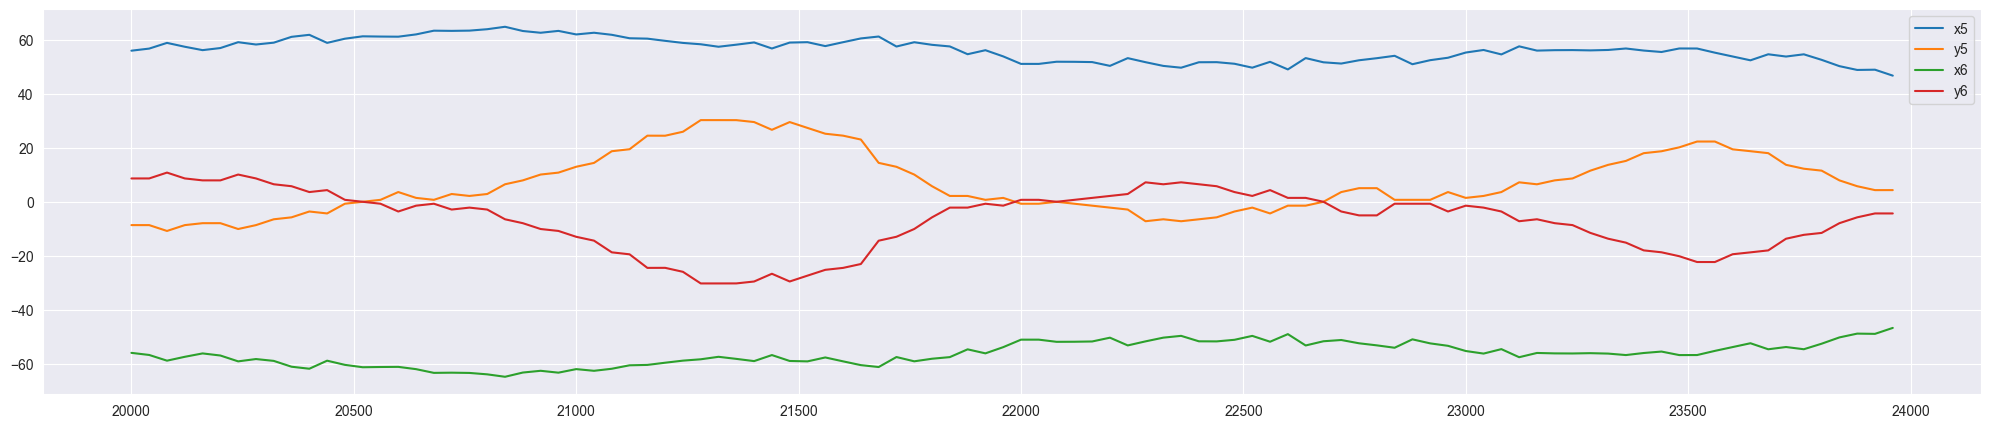

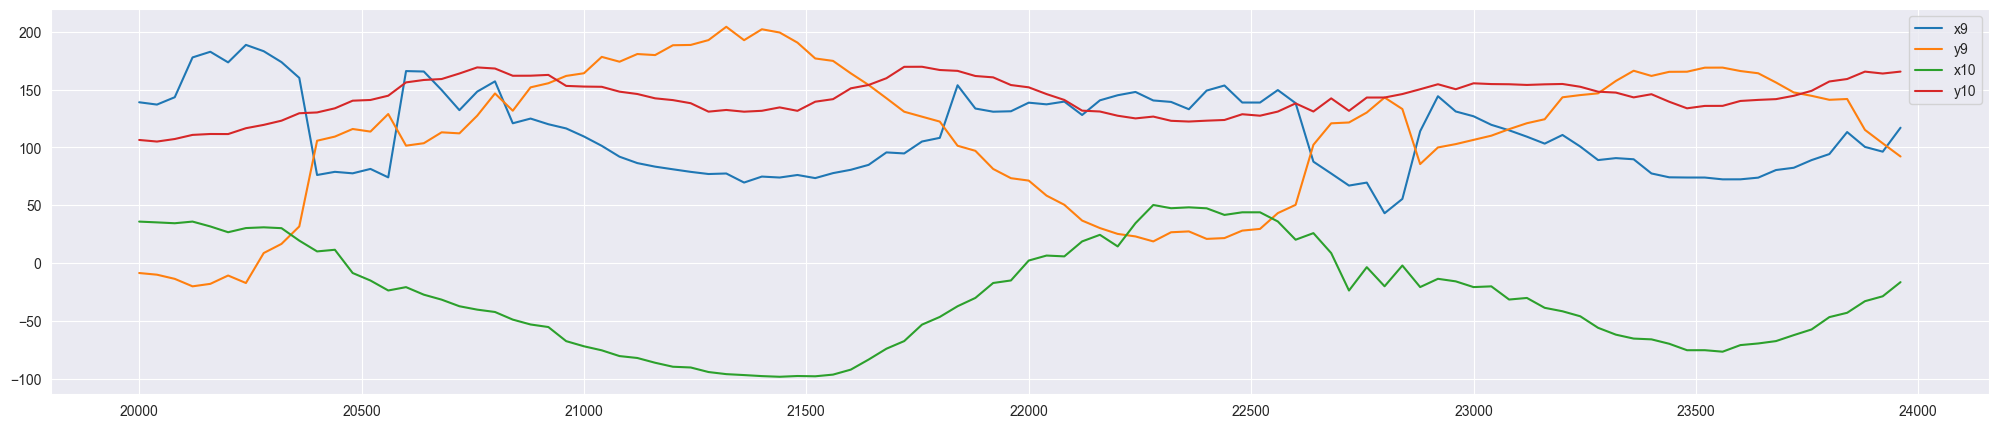

In [1167]:
plot()

In [1168]:
''' This is kinda meh'''
# # make keypoints the difference between the current and the previous keypoint, make the first row as 0
# keypoint_data['x5'] = keypoint_data['x5'].diff().fillna(0)
# keypoint_data['y5'] = keypoint_data['y5'].diff().fillna(0)
# keypoint_data['x6'] = keypoint_data['x6'].diff().fillna(0)
# keypoint_data['y6'] = keypoint_data['y6'].diff().fillna(0)
# keypoint_data['x9'] = keypoint_data['x9'].diff().fillna(0)
# keypoint_data['y9'] = keypoint_data['y9'].diff().fillna(0)
# keypoint_data['x10'] = keypoint_data['x10'].diff().fillna(0)
# keypoint_data['y10'] = keypoint_data['y10'].diff().fillna(0)

' This is kinda meh'

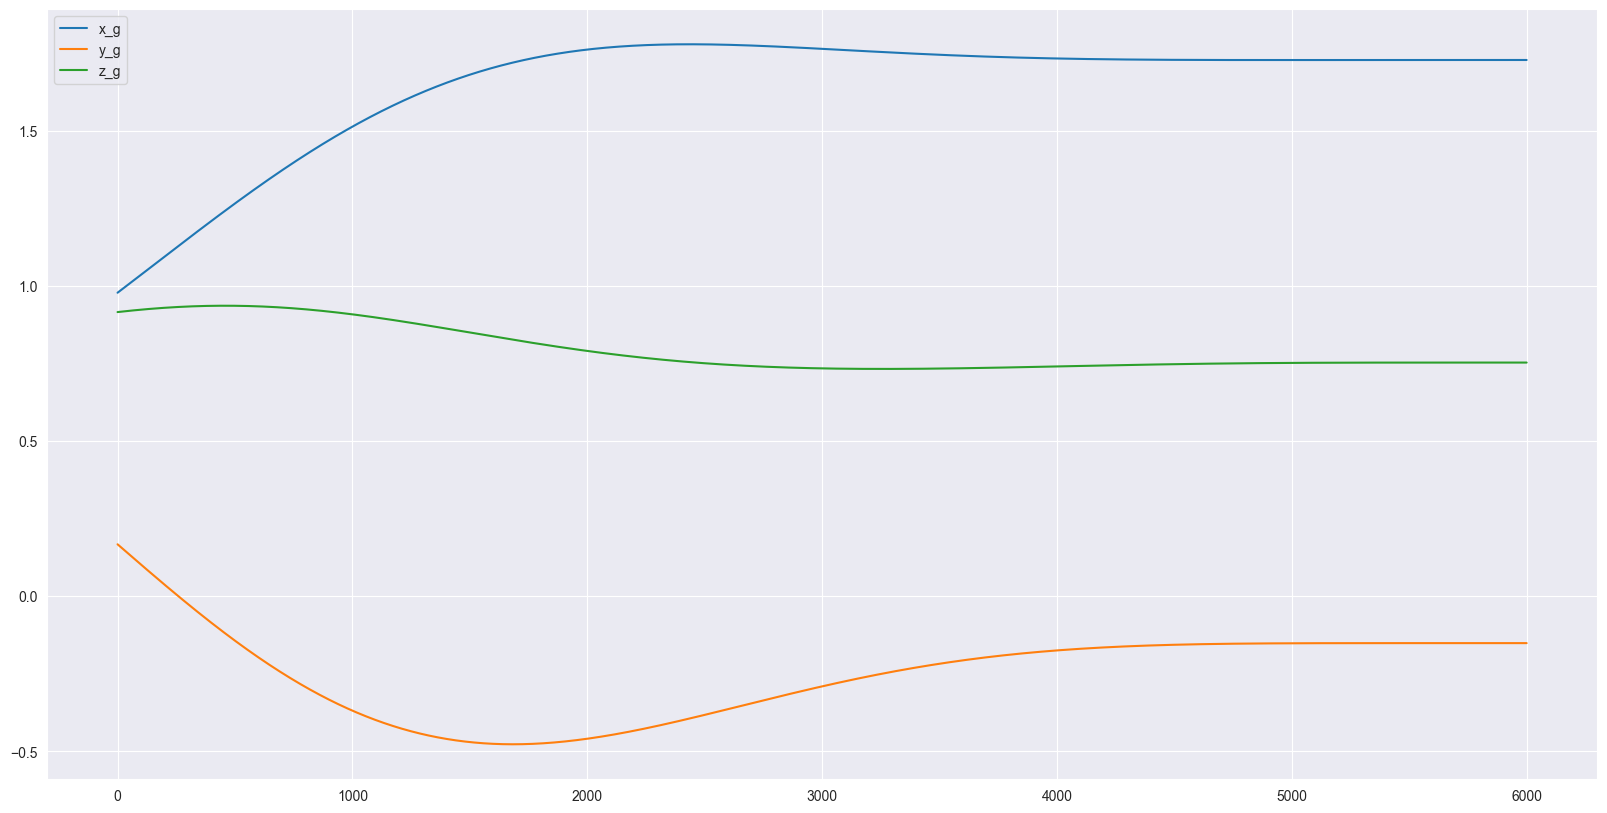

In [1169]:
#obtain gravity component
b, a, imu_data['x_g'] = lowpass_filter(imu_data['hand_Ax_g'].values, low_cut_off=0.1, fs=400)


b, a, imu_data['y_g'] = lowpass_filter(imu_data['hand_Ay_g'].values, low_cut_off=0.1, fs=400)

b, a, imu_data['z_g'] = lowpass_filter(imu_data['hand_Az_g'].values, low_cut_off=0.1, fs=400)

imu_data[['x_g', 'y_g', 'z_g']].plot(figsize=(20, 10))
plt.show()

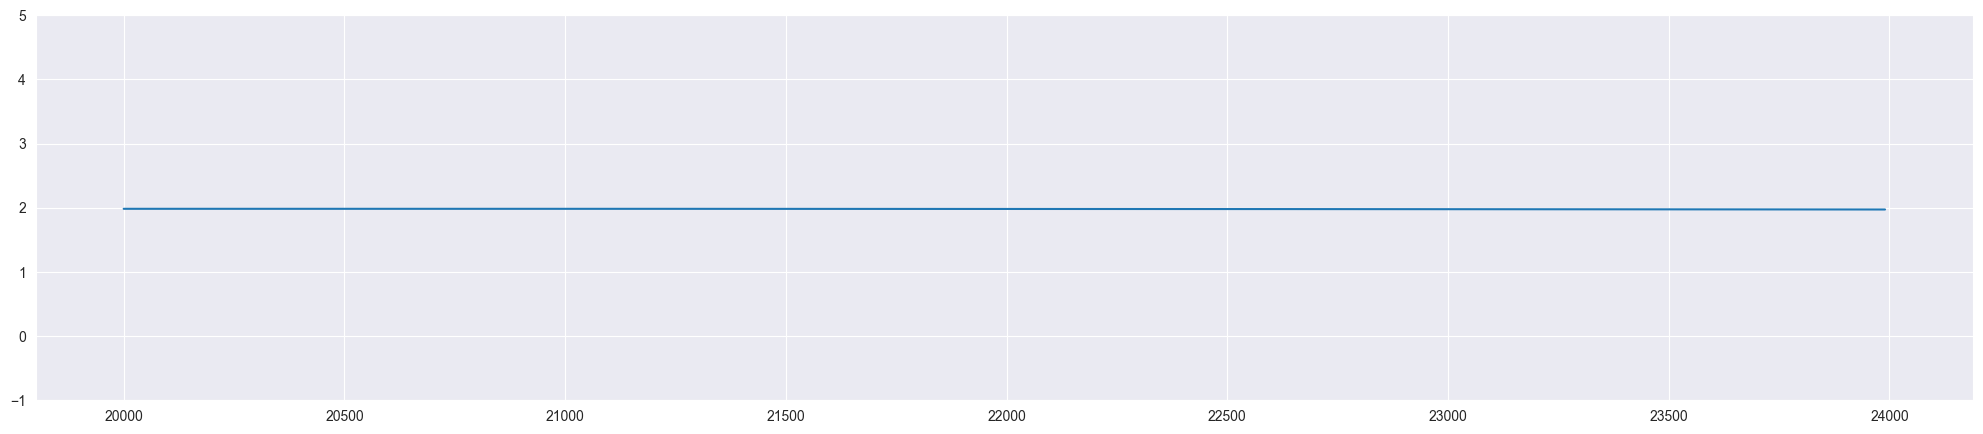

In [1170]:
# plot the magnitude of the gravity component
plt.figure(figsize=(25, 5))
plt.plot(imu_data['datetime'][imu_start:imu_end],
         np.sqrt(imu_data['x_g'][imu_start:imu_end] ** 2 + imu_data['y_g'][imu_start:imu_end] ** 2 +
                 imu_data['z_g'][imu_start:imu_end] ** 2))
# set ylim to -2 to 2
plt.ylim(-1, 5)
plt.show()

In [1171]:
# remove gravity component
imu_data['hand_Ax_g'] = imu_data['hand_Ax_g'] - imu_data['x_g']
imu_data['hand_Ay_g'] = imu_data['hand_Ay_g'] - imu_data['y_g']
imu_data['hand_Az_g'] = imu_data['hand_Az_g'] - imu_data['z_g']


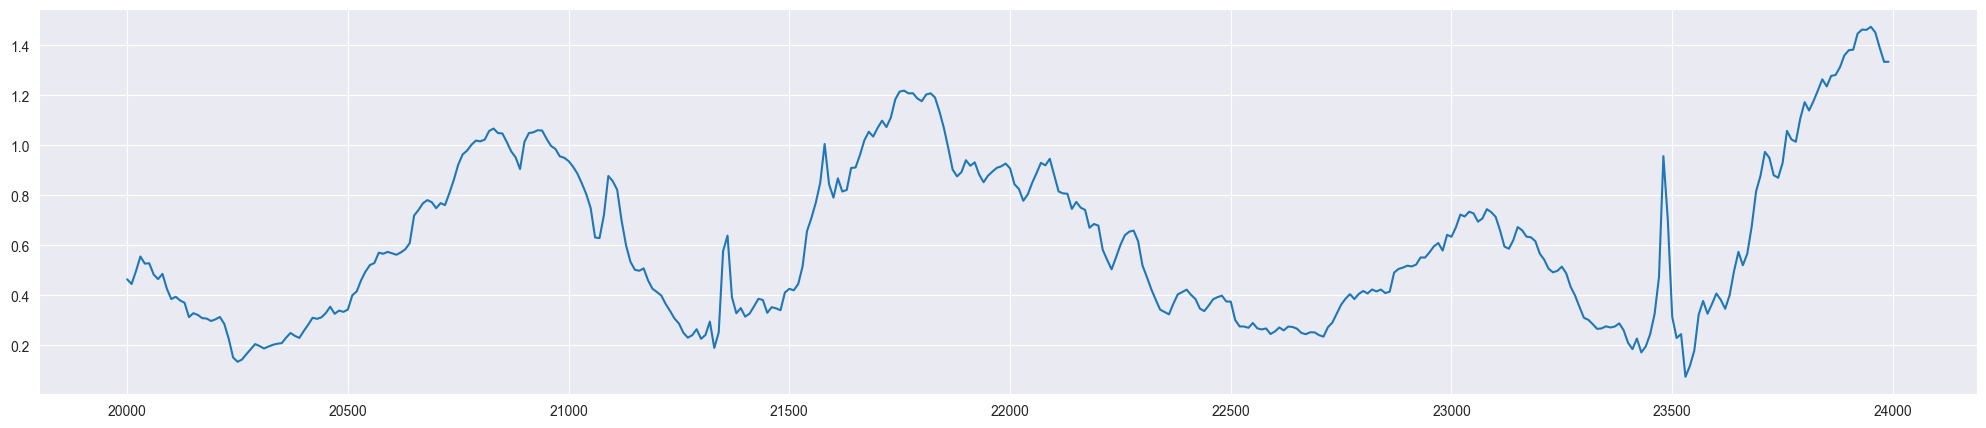

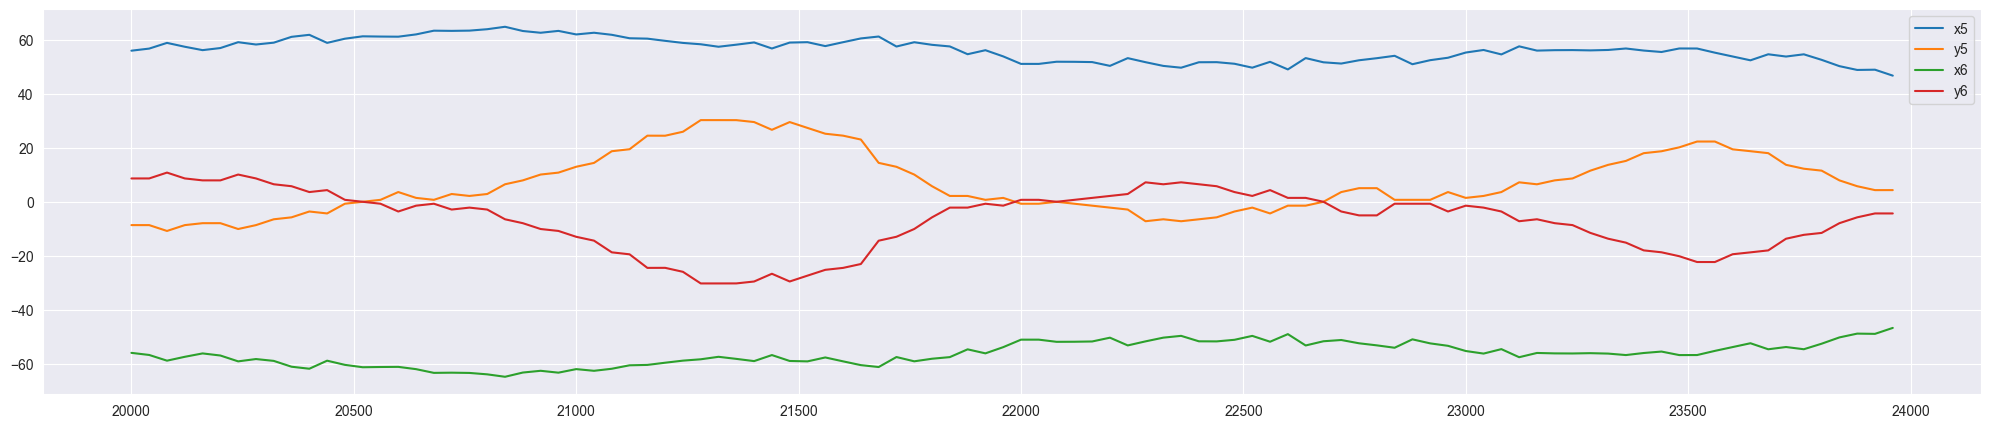

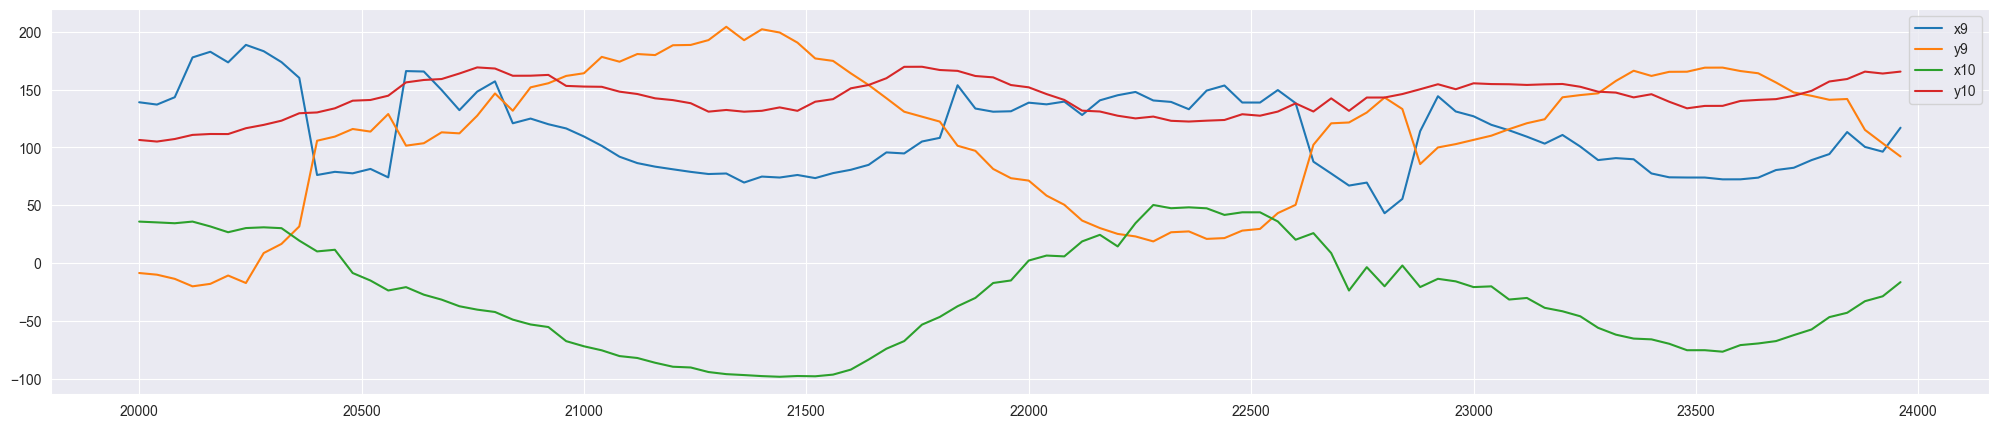

In [1172]:
plot()

In [1173]:
# remove the high frequency noise from the acceleration data
b, a, imu_data['hand_Ax_g'] = lowpass_filter(imu_data['hand_Ax_g'].values, low_cut_off=20, fs=400)
b, a, imu_data['hand_Ay_g'] = lowpass_filter(imu_data['hand_Ay_g'].values, low_cut_off=20, fs=400)
b, a, imu_data['hand_Az_g'] = lowpass_filter(imu_data['hand_Az_g'].values, low_cut_off=20, fs=400)


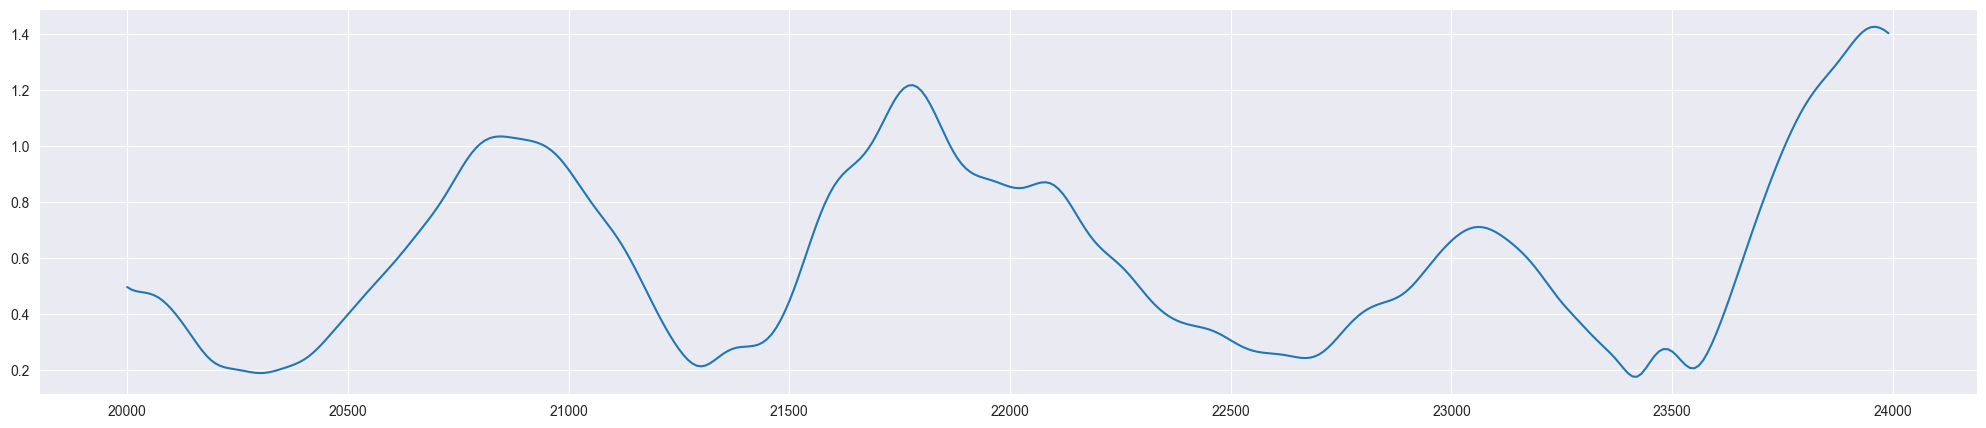

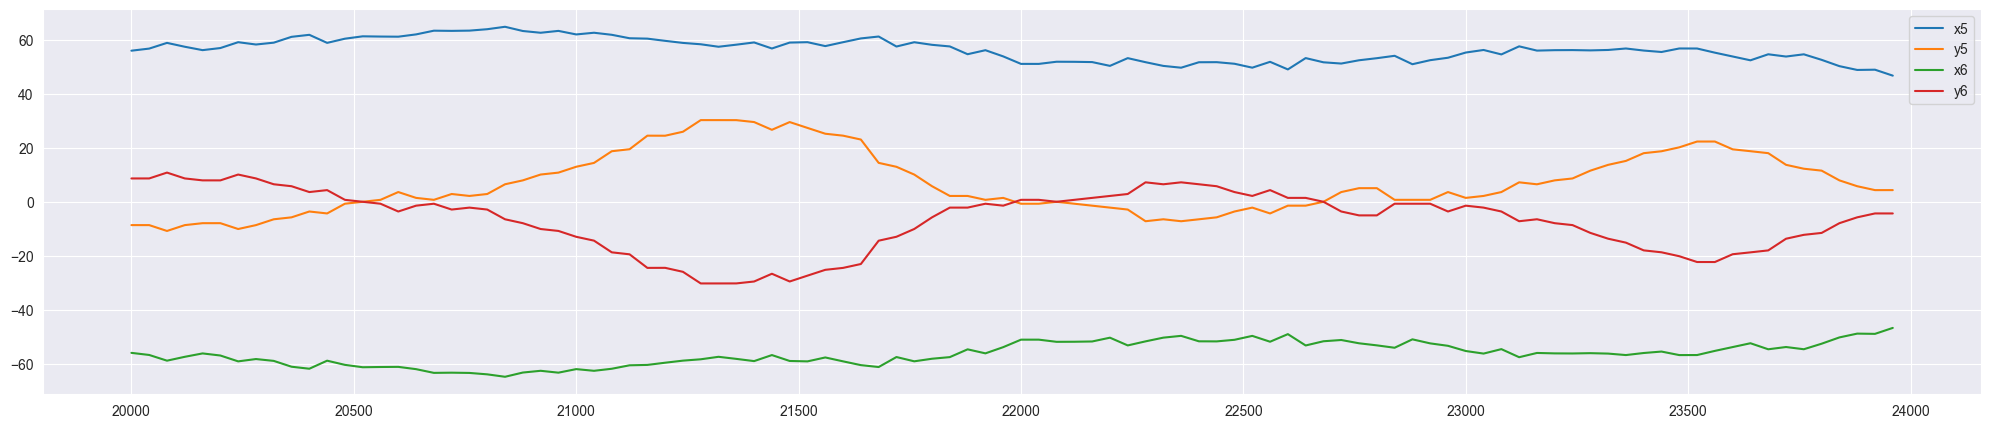

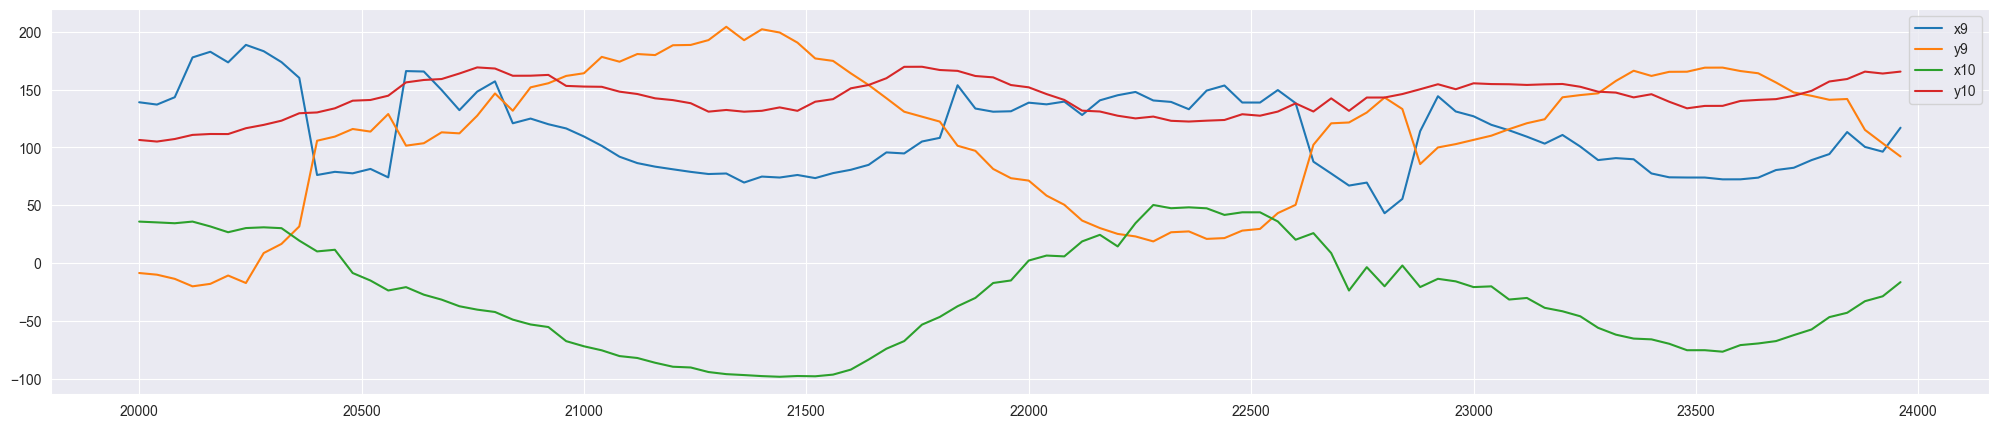

In [1174]:
plot()

In [1175]:
# divide all keypoint data by the distance
keypoint_data['x5'] = keypoint_data['x5'] / distance
keypoint_data['y5'] = keypoint_data['y5'] / distance
keypoint_data['x6'] = keypoint_data['x6'] / distance
keypoint_data['y6'] = keypoint_data['y6'] / distance
keypoint_data['x9'] = keypoint_data['x9'] / distance
keypoint_data['y9'] = keypoint_data['y9'] / distance
keypoint_data['x10'] = keypoint_data['x10'] / distance
keypoint_data['y10'] = keypoint_data['y10'] / distance


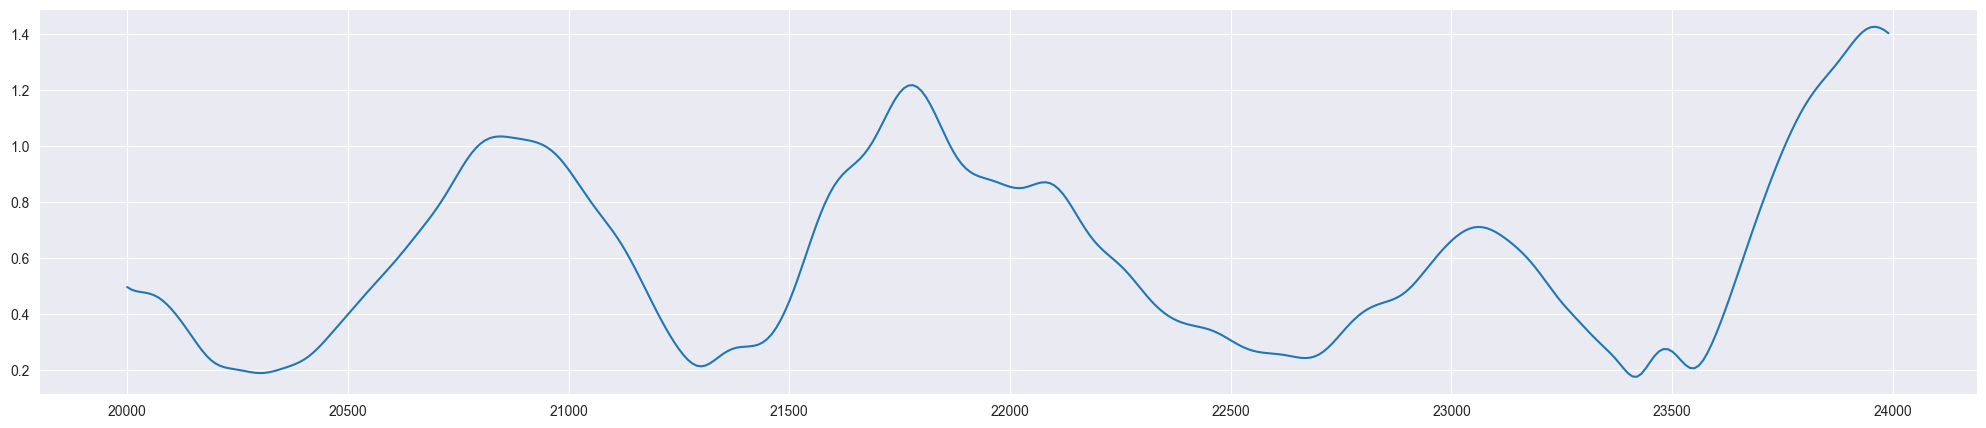

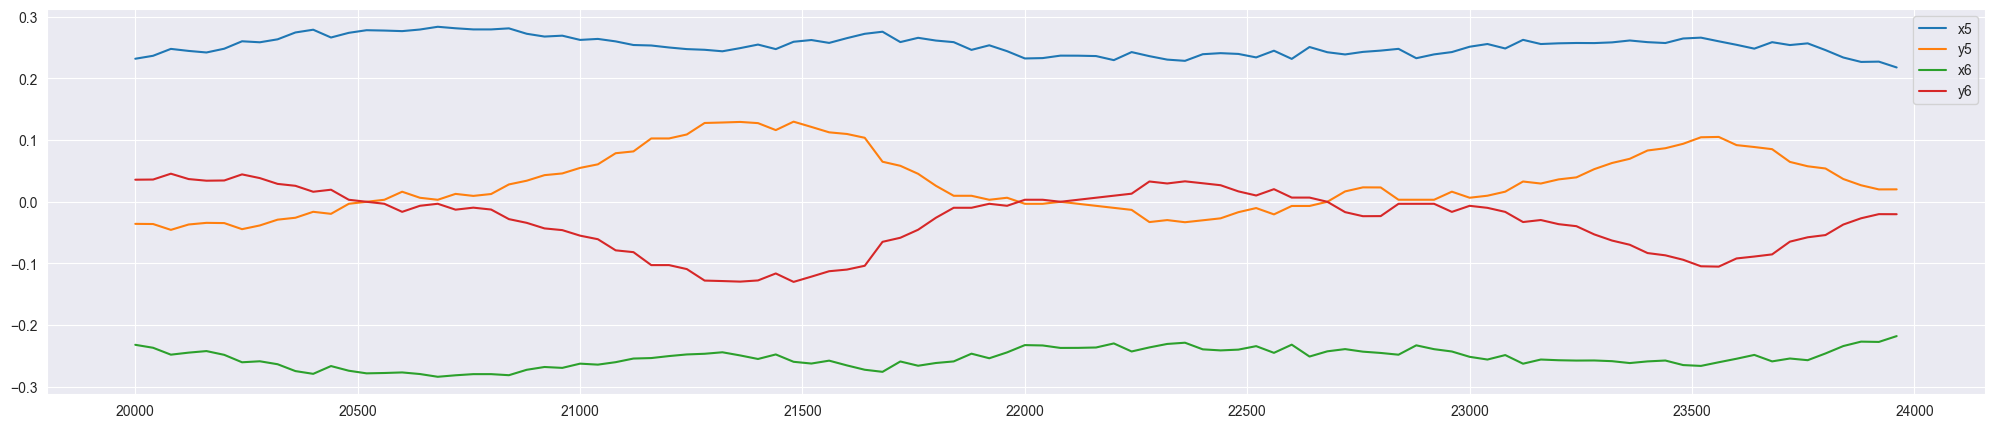

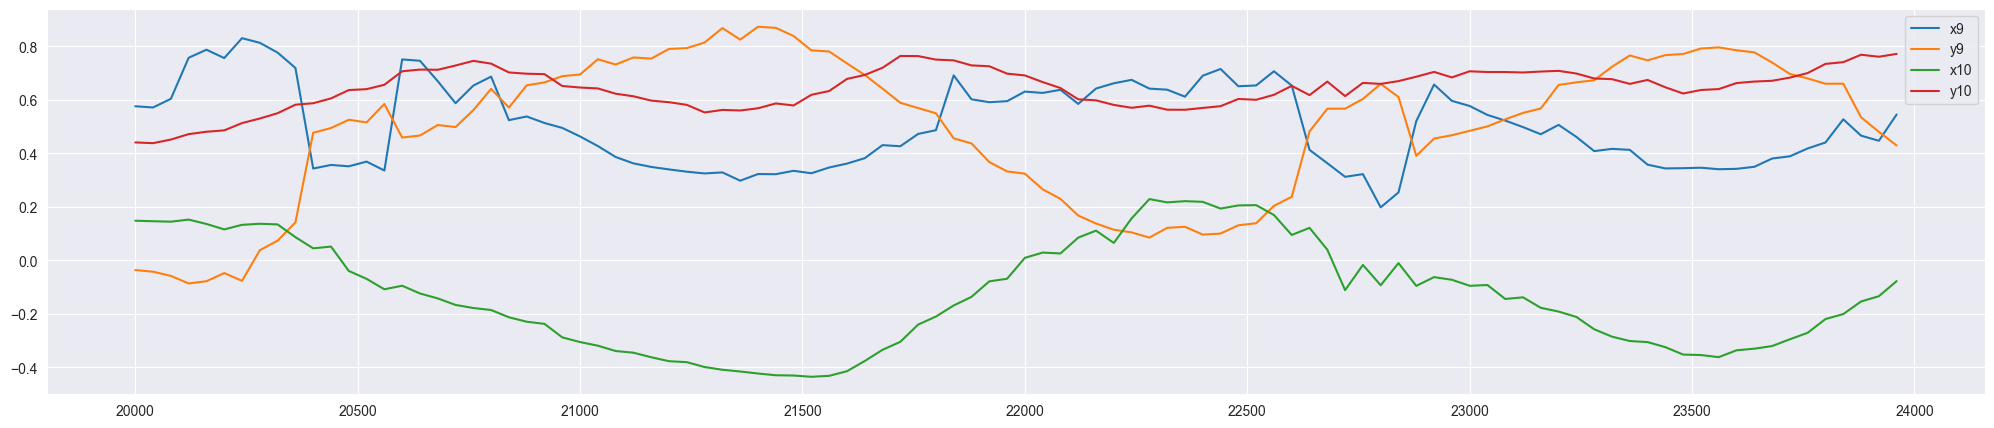

In [1176]:
plot()

In [1177]:
# create a new column for the magnitude of the acceleration
imu_data['hand_A'] = np.sqrt(imu_data['hand_Ax_g'] ** 2 + imu_data['hand_Ay_g'] ** 2 + imu_data['hand_Az_g'] ** 2)

In [1178]:
# from imu_data drop everything except the acceleration data and datetime
imu_data = imu_data[['datetime', 'hand_A']]

In [1179]:
from scipy.signal import resample

# resample the imu data to the same frequency as the keypoint data
imu_data = resample(imu_data, keypoint_data.shape[0])
# convert the resampled data to a dataframe
imu_data = pd.DataFrame(imu_data, columns=['datetime', 'hand_A'])

In [1180]:
# copy timestamp to datetime
imu_data['datetime'] = keypoint_data['timestamp'].copy()

In [1181]:
print(imu_data.shape)
print(keypoint_data.shape)
print(imu_data.head())
print(keypoint_data.head())

(1509, 2)
(1509, 54)
   datetime    hand_A
0         0  0.530011
1        40  0.920296
2        80  1.186904
3       120  1.528325
4       160  1.814527
   frame_number  timestamp       x0       y0   prob0       x1       y1  \
0             0          0  928.239  194.085  0.5061  932.548  182.574   
1             1         40  935.100  223.265  0.4153  937.980  204.547   
2             2         80  930.845  254.145  0.4246  935.152  242.626   
3             3        120  931.124  271.239  0.6784  933.997  258.300   
4             4        160  934.555  275.369  1.4008  934.555  262.432   

    prob1       x2       y2  ...      x14      y14  prob14      x15      y15  \
0  0.6430  912.438  182.574  ...  833.434  690.489  0.1099  916.747  843.008   
1  0.3984  919.259  208.867  ...  834.294  707.056  0.1188  910.619  862.560   
2  0.5136  912.182  242.626  ...  837.528  720.672  0.1187  900.697  870.421   
3  0.5938  916.761  256.863  ...  849.254  718.348  0.1784  898.089  870.739   
4 

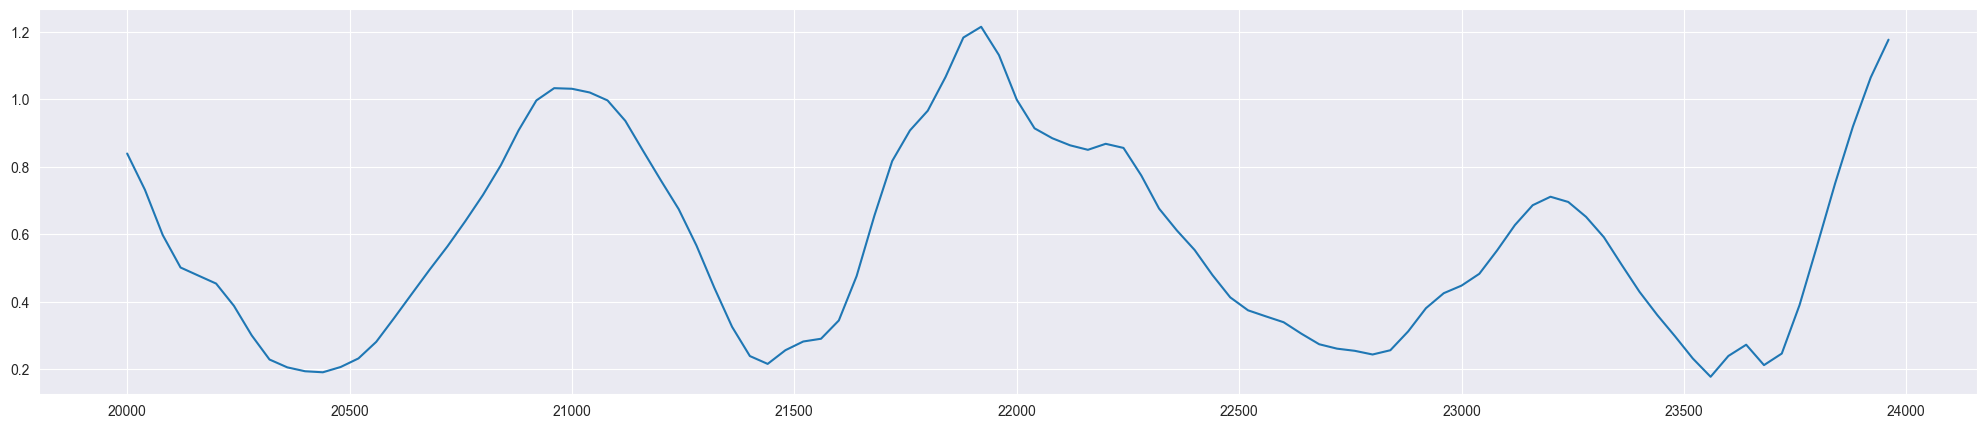

In [1182]:
imu_start = keypoint_start
imu_end = keypoint_end

# plot the magnitude of the acceleration
plt.figure(figsize=(25, 5))
plt.plot(imu_data['datetime'][imu_start:imu_end], imu_data['hand_A'][imu_start:imu_end])
plt.show()